# Setup

Start by loading the PETLION package

In [1]:
using PETLION

Loading the parameters for an LCO cell with 1D temperature enabled

In [2]:
@time p = petlion(LCO;
    N_p = 10, # discretizations in the cathode
    N_s = 10, # discretizations in the separator
    N_n = 10, # discretizations in the anode
    N_r_p = 10, # discretizations in the solid cathode particles
    N_r_n = 10, # discretizations in the solid anode particles
    temperature = true, # temperature enabled or disabled
    jacobian = :AD, # :AD (automatic-differenation) for convenience or :symbolic for speed
    );

 82.066481 seconds (202.10 M allocations: 12.424 GiB, 3.71% gc time, 96.55% compilation time)


First, start by setting the initial SOC and bounds for the states and outputs.

In [3]:
p.opts.SOC = 0 # fraction ∈ [0, 1]
p.opts.outputs = :all # save all the states and outputs from the simulation

p.bounds.T_max = 40 + 273.15 # K
p.bounds.V_max = 4.1 # V
p.bounds.I_max = 4 # C-rate
p.bounds.I_min = 1/20 # C-rate

0.05

# Simulation

Now, we can begin to run the simulation. Start by fast charging at the maximum C-rate.

In [4]:
sol = simulate(p, I=p.bounds.I_max)

PETLION simulation
 --------
 Run:     I
 Time:    357.56 s
 Current: 4C
 Voltage: 4.0312 V
 Power:   471.33 W/m²
 SOC:     0.3973
 Temp.:   40.0 °C
 Exit:    Above max. temperature

The final exit reason can be accessed using the command

In [5]:
final_exit_reason(sol)

"Above max. temperature"

We hit the temperature constraint, so let's hold the temperature constant using a constant temperature (CT) operating mode. The CT operating mode sets the *spatially averaged temperature*,

$$
\overline{T}(t) = \frac{1}{L}\int_0^L T(x,t) \, \mathrm{d}x,
$$

to $T_{\max}$. In the P2D model, the temperature does not have significant spatial variation. Numerically, the CT operating mode is achieved by setting

$$
\frac{\mathrm{d}\overline{T}}{\mathrm{d}t} = 0
$$

by solving for $I(t)$.

`simulate!` continues the previous simulation, where the `!` operator indicates it is modifying `sol`.

In [6]:
simulate!(sol, p, dT=:hold) # equivalent to `simulate!(sol, p, dT=0)`

PETLION simulation
 --------
 Runs:    I → dT
 Time:    686.41 s
 Current: 2.7892C
 Voltage: 4.1 V
 Power:   334.26 W/m²
 SOC:     0.6714
 Temp.:   40.0 °C
 Exit:    Above max. voltage

Now that we hit the voltage cap, so let's run a CV hold.

In [7]:
simulate!(sol, p, V=:hold)

PETLION simulation
 --------
 Runs:    I → dT → V
 Time:    1865.61 s
 Current: 0.1959C
 Voltage: 4.1 V
 Power:   23.47 W/m²
 SOC:     1.0
 Temp.:   25.6963 °C
 Exit:    Above max. SOC

The simulation terminates upon hitting the maximum SOC of `1`.

The list of exit reasons can be accessed using

In [8]:
exit_reasons(sol)

3-element Vector{String}:
 "Above max. temperature"
 "Above max. voltage"
 "Above max. SOC"

# Plotting

Let's load the plotting package and show the results

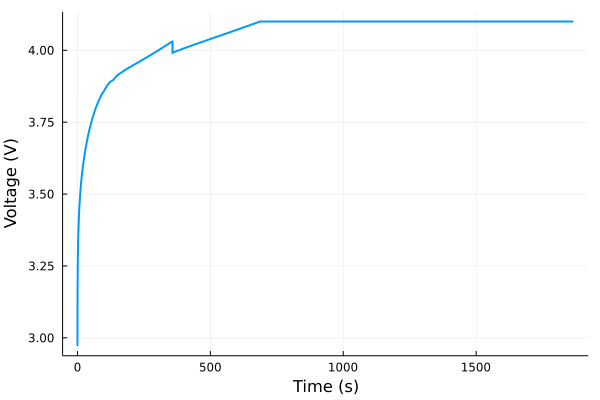

In [9]:
using Plots
plot(sol, :V) # Voltage

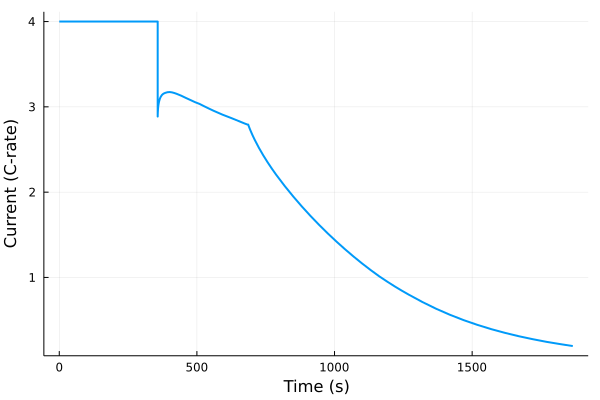

In [10]:
plot(sol, :I) # Current

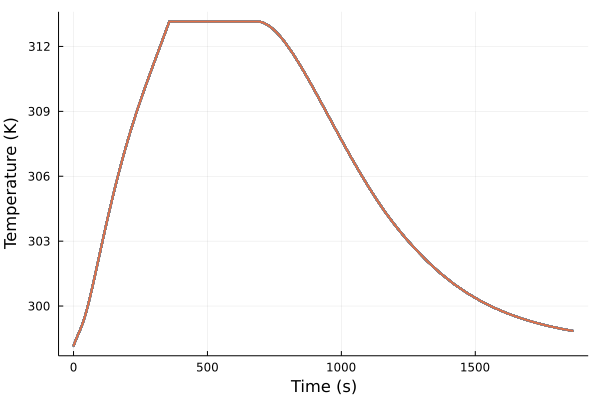

In [11]:
plot(sol, :T) # 1D temperature

Upon hitting $T_{\max}$ and entering the CT operating mode, the current drops precipitously to enforce the temperature constraint. At the CT-CV transition, the current drop is less dramatic.